In [2]:
# Import required modules
import cv2
import numpy as np
import os
import glob
import matplotlib.pyplot as plt


In [3]:
#calibrating camera using OpenCV method 
#https://www.geeksforgeeks.org/camera-calibration-with-python-opencv/
def cameraCalibrationOpenCV(images):
    CHECKERBOARD = (7, 10)
    criteria = (cv2.TERM_CRITERIA_EPS + 
                cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)
    threedpoints = []
    twodpoints = []
    objectp3d = np.zeros((1, CHECKERBOARD[0] 
                          * CHECKERBOARD[1], 
                          3), np.float32)
    objectp3d[0, :, :2] = np.mgrid[0:CHECKERBOARD[0],
                                   0:CHECKERBOARD[1]].T.reshape(-1, 2)
    prev_img_shape = None
    for filename in images:
        image = cv2.imread(filename)
        grayColor = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        ret, corners = cv2.findChessboardCorners(
                        grayColor, CHECKERBOARD, 
                        cv2.CALIB_CB_ADAPTIVE_THRESH 
                        + cv2.CALIB_CB_FAST_CHECK + 
                        cv2.CALIB_CB_NORMALIZE_IMAGE)
        if ret == True:
            threedpoints.append(objectp3d)
            corners2 = cv2.cornerSubPix(
                grayColor, corners, (11, 11), (-1, -1), criteria)

            twodpoints.append(corners2)
    ret, matrix, distortion, r_vecs, t_vecs = cv2.calibrateCamera(
    threedpoints, twodpoints, grayColor.shape[::-1], None, None)
    return matrix

In [14]:
#find the equation of a line
def findLineEquation(x,y):
    m = (y[1] - x[1]) / (y[0] - x[0])
    return -m, 1.0, m*y[0]-y[1] 

In [13]:
#find the intersetion of two lines
def findVP(points):
    a1, b1, c1 = findLineEquation(points[0], points[1])
    a2, b2, c2 = findLineEquation(points[2], points[3])
    VP = findIntersection((a1, b1, c1), (a2, b2, c2))
    return VP
def findIntersection(l1, l2):
    (a1, b1, c1) = l1
    (a2, b2, c2) = l2
    x = (-c2 + c1) / (-a1 + a2)
    y = (-a1 * x) - c1
    return (x, y)

In [4]:
#camera calibration function if fx=fy for the camera
def cameracalibrationVanishingPoints(p1,p2,p3):
    VP1 = findVP(p1)
    VP2 = findVP(p2)
    VP3 = findVP(p3)
    VPoints = [VP1,VP2, VP3]
    return findK(VPoints)

In [5]:
##camera calibration function if fx!=fy for the camera
def cameracalibrationVanishingPointsNonSameF(p1,p2,p3,p4):
    VP1 = findVP(p1)
    VP2 = findVP(p2)
    VP3 = findVP(p3)
    VP4 = findVP(p4)
    VPoints = [VP1,VP2, VP3,VP4]
    return findKNonSameF(VPoints)

In [6]:
#function to find K which is called by the function cameracalibrationVanishingPoints
def findK(VP):
    Omega = []
    for i, point_i in enumerate(VP):
        for j, point_j in enumerate(VP):
            if i != j and j > i:
                P1 = [point_i[0],point_i[1],1.0]
                P2 = [point_j[0],point_j[1],1.0]
                Omega.append([P1[0]*P2[0]+P1[1]*P2[1],P1[0]*P2[2]+P1[2]*P2[0],P1[1]*P2[2]+P1[2]*P2[1],P1[2]*P2[2]])
    Omega = np.array(Omega)
    U, S, V = np.linalg.svd(Omega)
    x1, x2, x3, x4 = V.T[:,-1]
    x = np.array([[x1, 0., x2],
                  [0., x1, x3],
                  [x2, x3, x4]])
    KT = np.linalg.cholesky(x)
    K = np.linalg.inv(KT.T)
    K = K / K[-1, -1]
    return K

In [ ]:
def findKNonSameF(VP):
    Omega = []
    for i, point_i in enumerate(VP):
        for j, point_j in enumerate(VP):
            if i != j and j > i:
                P1 = [point_i[0],point_i[1],1.0]
                P2 = [point_j[0],point_j[1],1.0]
                Omega.append([P1[0]*P2[0],P1[1]*P2[1],P1[0]*P2[2]+P1[2]*P2[0],P1[1]*P2[2]+P1[2]*P2[1],P1[2]*P2[2]])
    Omega = np.array(Omega)
    U, S, V = np.linalg.svd(Omega)
    x1, x2, x3, x4, x5 = V.T[:,-1]
    x = np.array([[x1, 0., x3],
                  [0., x2, x4],
                  [x3, x4, x5]])
    KT = np.linalg.cholesky(x)
    K = np.linalg.inv(KT.T)
    K = K / K[-1, -1]
    return K

In [8]:
imgPath="img/"

In [9]:
calibrationImagesOpenCV=glob.glob(imgPath+'calibrationOpenCV/calibration*.png')
KOpenCV=cameraCalibrationOpenCV(calibrationImagesOpenCV)
print("The intrinsic matrix obtained from opencv is ", KOpenCV)

The intrinsic matrix obtained from opencv is  [[970.83083531   0.         618.80007608]
 [  0.         968.84623889 793.37488507]
 [  0.           0.           1.        ]]


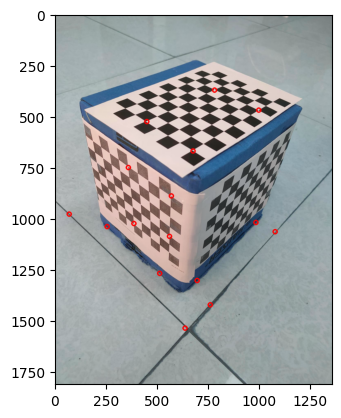

In [10]:
p1=np.array([[69,979],[635,1537],[254,1040],[511,1269]])
p2=np.array([[448,526],[779,372],[674,670],[995,470]])
p3=np.array([[358,751],[385,1025],[568,890],[559,1088]])
p4=np.array([[694,1304],[981,1020],[758,1423],[1075,1065]])
img = cv2.imread('img/checkerboardCube.png')
for i in range(len(p1)):
    cv2.circle(img, (int(p1[i][0]),int(p1[i][1])), 10, (255, 0, 0), 5)
    cv2.circle(img, (int(p2[i][0]),int(p2[i][1])), 10, (255, 0, 0), 5)
    cv2.circle(img, (int(p3[i][0]),int(p3[i][1])), 10, (255, 0, 0), 5)
    cv2.circle(img, (int(p4[i][0]),int(p4[i][1])), 10, (255, 0, 0), 5)
plt.imshow(img)

In [15]:
KVP=cameracalibrationVanishingPoints(p1,p2,p3)

In [16]:
print("The intrinsic matrix obtained from opencv is ", KVP)

The intrinsic matrix obtained from opencv is  [[1.21489000e+03 0.00000000e+00 4.16916924e+02]
 [0.00000000e+00 1.21489000e+03 8.81331121e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
